<a href="https://colab.research.google.com/github/masepi/Wuhan/blob/master/WuhanDeathRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import differential_evolution


Статистика по дням:

In [0]:
new_incidents = np.array([40, 4, 17, 59, 77, 93, 149, 131, 259, 457, 688, 769, 1771, 1459, 1737, 1981, 2099, 2589, 2825, 3235, 3884, 3694, 3143, 3385, 2652, 2973, 2467, 2015, 15151, 4047, 2641, 2008, 2048, 1888, 1749 ], dtype=np.float)
deahts_cummulative = np.array([1, 2, 2, 3, 3, 6, 9, 17, 25, 41, 56, 80, 106, 132, 170, 213, 259, 304, 361, 425, 490, 563, 637, 722, 811, 908, 1016, 1113, 1259, 1380, 1523, 1665, 1770, 1868, 2004 ], dtype=np.float)
assert len(new_incidents) == len(deahts_cummulative)
days_count = len(new_incidents)

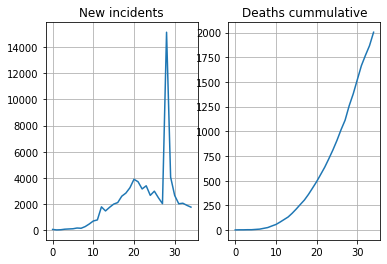

In [0]:
plt.subplot(121)
plt.title('New incidents')
plt.plot(new_incidents)
plt.grid(True)

plt.subplot(122)
plt.title('Deaths cummulative')
plt.plot(deahts_cummulative)
plt.grid(True)

Суммарное количество смертей на день N вычисляется по формуле:

![alt text](http://latex2png.com/pngs/fc8f410d87ea3ec381353e4f8ae94c79.png)

Здесь N<sub>d</sub> - число новых случаев на день d, D<sub>i</sub> - средняя ожидаемая доля умерших от заболевших на i день болезни. 
D<sub>i</sub> - **неубывающая функция**, имеющая своим пределом смертность.

Это выражение должно быть верно на каждый день N, поэтому имеем N + 1 уравнение,
или в матричном виде:

![alt text](http://latex2png.com/pngs/2afa1ad324b4e087d426ca7fc9b1f29f.png)

Где,

![alt text](http://latex2png.com/pngs/d1eb7f1eb65dce68990d83652d97a0dc.png)

![alt text](http://latex2png.com/pngs/4b9cab3092df722b6e397d20752bd53b.png)    

In [0]:
N_matrix = np.zeros((days_count, days_count), dtype=np.float)
for i in range(0, days_count):
    for j in range(0, i+1):
        N_matrix[i, j] = new_incidents[i-j]

print('shape=', N_matrix.shape)
print(N_matrix)


shape= (35, 35)
[[  40.    0.    0. ...    0.    0.    0.]
 [   4.   40.    0. ...    0.    0.    0.]
 [  17.    4.   40. ...    0.    0.    0.]
 ...
 [2048. 2008. 2641. ...   40.    0.    0.]
 [1888. 2048. 2008. ...    4.   40.    0.]
 [1749. 1888. 2048. ...   17.    4.   40.]]


Мы хотим найти вектор D по известным N<sub>matrix</sub> и D<sub>cummulative</sub>

Проблема в том, что данным содержам в себе ошибки, а уравнение верно только при статистическом усреднении. К тому же D - неубывающая величина.

Поэтому решать будем дифференциальной эволюцией.


In [0]:
# Метод вычисляем вектор D по параметрам дифф. эволюции
# Ищем ввиде неубывающей функции
def produce_D(evol_params):
    death_rate = evol_params[-1] # в последнем параметр лежит death_rate
    evol_params_coeffs = np.array(evol_params[0:len(evol_params)-1])
    d_sum = sum(evol_params_coeffs)
    evol_params_coeffs = evol_params_coeffs / d_sum * death_rate
    D = [0]
    for i in range(len(evol_params_coeffs)):
        D.append( D[-1] + evol_params_coeffs[i] )
    return D

# Функция ошибок, которую минимизируем - средняя предсказаний смертей по дням.
def dif_evol_error(evol_params):
    D = produce_D(evol_params)

    deaths = np.dot(N_matrix, D)
    error = np.sum(np.abs(deaths-deahts_cummulative))/days_count
    return error

callback_iter = 0
def callback(xk, convergence):
    global callback_iter
    error = dif_evol_error(xk)
    if callback_iter % 20 == 0:
      print(callback_iter, 'death_rate=', xk[-1], 'error=', error)
    callback_iter += 1


# Границы параметров дифф. эволюции
bound = [(0, 1)] * days_count


In [0]:
callback_iter = 0
evol_params_solution = differential_evolution(dif_evol_error, bounds=bound, maxiter=200, callback=callback, popsize=40, strategy='best2bin')



0 death_rate= 0.09191510301499134 error= 80.44099774278591
20 death_rate= 0.09644332171588665 error= 63.015177968993015
40 death_rate= 0.08978552399243023 error= 55.88959451955081
60 death_rate= 0.07678959878107561 error= 50.969989143948546
80 death_rate= 0.07678959878107561 error= 50.969989143948546
100 death_rate= 0.07776748176185716 error= 47.64455621404114
120 death_rate= 0.07776748176185716 error= 47.64455621404114
140 death_rate= 0.07776748176185716 error= 47.64455621404114
160 death_rate= 0.08751422321778479 error= 43.71768876830244
180 death_rate= 0.08751422321778479 error= 43.71768876830244


Выводим результаты и сравниваем расчетное число смертей с настоящим

Total death rate= 0.08559453013898169
error= 29.226371588449503
D= [0, 0.007874671073758811, 0.015266371443511307, 0.02108205647801225, 0.02611515301570752, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.02794785687012589, 0.028118483286443955, 0.028118483286443955, 0.028118483286443955, 0.029036769975778323, 0.033473404992525914, 0.03653000795216061, 0.04082175854842523, 0.04348582092320694, 0.051360491996965754, 0.052936872627830284, 0.05804164674427753, 0.06591631781803634, 0.07254824129655307, 0.07764774264771654, 0.08190209550829008, 0.08464824990180356, 0.08559453013898169]


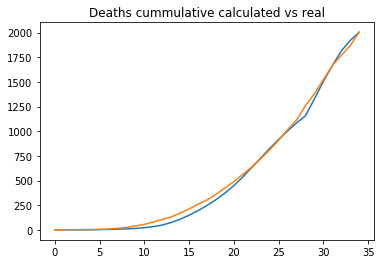

In [63]:
evol_params = evol_params_solution.x

print('Total death rate=', evol_params[-1])
print('error=', dif_evol_error(evol_params))
d = produce_D(evol_params)
print('D=', d)
deahts_cummulative_predicted = np.dot(N_matrix, d)

plt.title('Deaths cummulative calculated vs real')
plt.plot(deahts_cummulative_predicted)
plt.plot(deahts_cummulative)
plt.show()
